# Logistic regression as a neural network in pytorch

This notebook is an introduction to building machine learning systems with pytorch, https://pytorch.org/
We show how to build a logistic regression model in pytorch and introduce some of its basic functionalities.

pytorch is a Python package that lets you build different machine learning models to fit your problem, flexibly putting together different machine learning architectures. 


# Tensors in pytorch

In class we have formulated logistic regression in terms of vectors: Say our input $x$ is given as a list of features, $\langle x_1, x_2, x_3, x_4\rangle$, and we have logistic regression weights $\langle w_1, w_2, w_3, w_4\rangle$ (where we assume the bias is $w_4$ and that it goes with a "feature" $x_4$ that is always set to 1). Then the model's prediction is

$P(yes | x) = \sigma(w_1 x_1 + w_2 x_2 + w_3 x_3 + w_4x_4)$

Viewing $x$ as a vector of feature values and $w$ as a vector of weights, we write this briefly as 

$P(yes| x) = \sigma(\mathbf{w}\mathbf{x})$

When we have a training dataset of, say, 1,000 datapoints, each a vector of 4 feature values, we can consider the whole training set as one big matrix with 1,000 rows and 4 columns. Computing a weighted sum of values for each row, and then applying the sigmoid function to each row, we get a vector of predicted y values, one for each datapoint. 

So as you can see, vectors and matrices, or more generally *tensors*, are important in formulating machine learning models. You have already seen vectors and matrices in numpy. In pytorch, we have tensors, which offer many of the same operations as numpy ndarrays. What is different about pytorch tensors? They can be computed on a graphics processing unit (GPU) on some computers, speeding up processing. They can also optionally keep track of which tensors were combined and in what way, to enable automatic computation of derivatives. 

Here are some examples: 

In [1]:
# here's a numpy array
import numpy as np

data = [[1, 2],[3, 4]]
a = np.array(data)
a

array([[1, 2],
       [3, 4]])

In [2]:
# here's a torch tensor
import torch

b = torch.tensor(data)
b

tensor([[1, 2],
        [3, 4]])

In [3]:
# you can also make a torch tensor from a numpy array
c = torch.from_numpy(a)
c

tensor([[1, 2],
        [3, 4]])

In [4]:
# here's a torch tensor that is all zeros, with 
# 3 rows of 4 columns each
d = torch.zeros((3,4))
d

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

Here is how to take a vector of input values, make a weighted sum of them, and then apply the sigmoid function, all with torch tensors:

In [5]:
# here are three input feature values
inputs = torch.tensor([1., 2., 3.])
inputs

tensor([1., 2., 3.])

In [6]:
# and three weights to match
weights = torch.tensor([0.1, 0.2, 0.3])
weights

tensor([0.1000, 0.2000, 0.3000])

In [7]:
# sum(x_i * w_i): this is the same as the dot product
inputs.dot(weights)

tensor(1.4000)

In [8]:
# sigma( sum(x_i * w_i))
torch.sigmoid(inputs.dot(weights))

tensor(0.8022)

# Some artificial data

In order to demonstrate logistic regression, we need some data. We'll make some artificial data, using sklearn's `make_blobs`. If you're curious, here's more information about this function: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

In [9]:
from sklearn.datasets import make_blobs
# This will make a matrix X of datapoints
# containing 10 data points
# for 2 different classes y,
# with 2 features per datapoint
# and a fixed random state so you get the same vectors again
# when you re-run
X, y = make_blobs(n_samples=10, centers=2, n_features=2, random_state=0)

# here are the vectors
X

array([[ 1.12031365,  5.75806083],
       [-0.49772229,  1.55128226],
       [ 1.9263585 ,  4.15243012],
       [ 2.49913075,  1.23133799],
       [ 3.54934659,  0.6925054 ],
       [ 1.7373078 ,  4.42546234],
       [ 2.91970372,  0.15549864],
       [ 2.84382807,  3.32650945],
       [ 0.87305123,  4.71438583],
       [ 2.36833522,  0.04356792]])

In [10]:
# and here is a class for each vector
y

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 1])

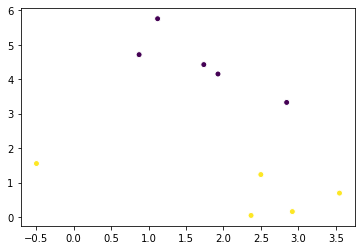

In [11]:
%matplotlib inline

# Let's plot the vectors. 
# Class 0 is purple, class 1 is yellow
# (or the other way round, I'm not quite sure)
# As you can see, the two classes are nicely separate
# You could draw a line between them
# so this should be easy data to model
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y, edgecolors='w');

We re-run `make_blobs` with more datapoints and more features per datapoint to make the task a bit more challenging. We keep 2 output classes (to match what logistic regression can do), which will again be easily distinguishable because that's what `make_blobs` does. 

In [12]:
# getting a bit more data
X, y = make_blobs(n_samples=100, centers=2, n_features=5, random_state=0)

In [13]:
# Here's our very first datapoint
X[0,]

array([ 2.33661378, -2.8808903 ,  6.26769229,  8.09409728, -1.02974155])

# Automatic derivatives: Autograd


Here's a reminder of how learning works in a logistic regression model, and in fact generally in the machine learning models for which pytorch is made: You have a *loss function* that tells you how far the predicted output y-hat (or `y_pred` in this notebook) is away from the true label y. This loss function is formulated in terms of the parameters of the model -- the weights. You can view the loss function as a "mountain range of error": The higher, the worse. The derivative of the loss function tells you, at each point in the loss function, which is "the fastest way down": the direction in which to change the weights in order to lower your loss the most. Learning then means:
* making a prediction y-hat /`y_pred` for a datapoint x
* using the loss function to determine how far off the model is
* using the derivative of the loss function to see how to change the weights
* taking *one step* in the direction pointed out by the derivative. You don't want the step to be too large, as different data points may point you in slightly different ways to go. You use a parameter that is called the *step size* to determine how far to go. 

(In practice, we do this not one datapoint at a time, but one *minibatch* of datapoints at a time, to save time.)

We say we use the model in the *forward* direction to make a prediction, and then change the weights going *backward* from the last to the first layer of weights. 

Tensors in pytorch can optionally keep track of how they were computed, in what is called a *computation graph*. You can then simply call the `backward()` method on the loss to compute the derivative and the direction in which the weights should change. 

Here's what this looks like for logistic regression:

In [14]:
# We turn our matrix X of data and vector y of true class values
# into torch tensors
x_data = torch.from_numpy(X).float()
y_data = torch.from_numpy(y).float()

In [15]:
# on my computer, I can't run on a graphics processing unit.
# try if it will work on yours
if torch.cuda.is_available():
    device = 'cuda' 
else:
    device = 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [16]:
# Here is a random vector of 5 weights
# (It's 5 because we made data with 5 features above.)
# Importantly, we set requires_grad = True,
# that is, we ask pytorch to keep track of w in the computation graph
w = torch.randn(5, 1, device=device, requires_grad=True)

In [17]:
w

tensor([[ 0.2732],
        [-1.0207],
        [ 0.3918],
        [ 0.9078],
        [-1.1485]], requires_grad=True)

In [18]:
# we make a weighted sum of feature values for each datapoint
# in our training dataset:
# this is a hidden for-loop,
# for each row in the training data,
# compute weighted sum with weights w
# weighted_sums is a vector of weighted sums,
# one per training data point
weighted_sums = torch.matmul(x_data, w)

# for each datapoint in the training dataset,
# our prediction is sigmoid(weighted_sum):
# this is a hidden for-loop:
# for each entry in weighted_sums vector,
# apply sigmoid.
# y-pred is a vector of predictions P(yes | x)
y_pred = torch.sigmoid(weighted_sums)

# Loss function: sum of squared errors
# sum_i(y_pred_i - y_i)^2
# loss is one number.
# for each data point: 
# compute difference(prediction, trueclass), square,
# take sum of squared differences. 
loss = (y_pred - y_data).pow(2).sum()

# As you can see, the loss is associated with a gradient function
# that shows how the loss was computed
loss

tensor(4252.5454, grad_fn=<SumBackward0>)

In [19]:
y_pred

tensor([[1.0000],
        [0.2691],
        [0.7965],
        [0.2548],
        [1.0000],
        [0.2590],
        [0.0450],
        [1.0000],
        [0.6312],
        [1.0000],
        [0.0551],
        [0.6476],
        [1.0000],
        [0.5524],
        [0.8023],
        [0.0655],
        [1.0000],
        [1.0000],
        [0.2655],
        [1.0000],
        [0.0806],
        [0.9303],
        [0.5354],
        [0.5265],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.3487],
        [0.0240],
        [0.3894],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.1392],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.7016],
        [1.0000],
        [0.0757],
        [1.0000],
        [1.0000],
        [0.4459],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.0671],
        [1.0000],
        [0.2654],
        [0.1128],
        [0.0912],
        [0.0308],
        [1.0000],
        [0.9462],
        [0

In [20]:
# Here are our weights before adjustment
w

tensor([[ 0.2732],
        [-1.0207],
        [ 0.3918],
        [ 0.9078],
        [-1.1485]], requires_grad=True)

In [21]:
# do the backward step:
# compute the derivative of the loss
loss.backward()

In [22]:
# size of the step we are taking: 
# learning rate. 
# pretty small.
learning_rate = 1e-6

# while we adjust the weights,
# we don't keep track of the gradient.
# we only need to keep track of the gradient
# in the forward step
with torch.no_grad():
    # adjust the weights by learning_rate * gradient-of-weights
    # w.grad was set by the call to backward() above.
    w -= learning_rate * w.grad
    


In [23]:
# Here are the weights after adjustment: 
# just a tiny bit different from before
w

tensor([[ 0.2733],
        [-1.0200],
        [ 0.3921],
        [ 0.9078],
        [-1.1487]], requires_grad=True)

# Layers of a machine learning model

When we look beyond logistic regression to deeper machine learning models, the current standard way to think about the models is in terms of layers. In a logistic regression model, we have:
* a "linear layer", a weighted sum of inputs $z = w \cdot x$.  
* Then a nonlinear function, in our case a sigmoid.

Deep learning models have multiple layers, for example: a linear layer, followed by a nonlinearity (which can be a sigmoid or any of a large collection of options), then another linear layer, then another nonlinearity, then output.

pytorch makes it easy for you to build deep learning models by pre-defining many different types of layers, which you can then combine. Check them out here: https://pytorch.org/docs/stable/nn.html

The way to use them in pytorch is to define a class of objects that characterizes your machine learning model. To explain this, we need to take a detour: 

## A very short introduction to object orientation

You know how some data types come with their own methods, which you can use by saying `[object of this data type].[method]()`, for example 


In [24]:
mystring = "Hello"
mystring.lower()

'hello'

These methods can be quite involved, for example gensim's spaces come with a method `similarity()`, which computes cosine similarity, and a method `most_similar()`, which computes nearest neighbors. 

As it turns out, you can make your own such data types. You can give them pieces of data they contain, and methods. Here is a simple example:

In [25]:
class MyDataObject:
    # __init__() is the function that will be called when you make an object of this class.
    # methods are always defined with one extra argument that you do not specify
    # when you call them, a "self". 
    def __init__(self, data):
        self.data = data
        
    def showdata(self):
        print("Hello, my data is:", self.data)

This makes a new class of objects, which contains a piece of data, and a method. You can make an object that is an instance of this class. 

In [26]:
# This calls the __init__ function of MyDataObject, with 
# self set to the object that gets stored in a. 
# The __init__ function stores the string 'muon' in the 
# variable 'data'
a = MyDataObject("muon")

# This calls the showdata() function on the object a. 
a.showdata()

Hello, my data is: muon


In [27]:
# If you make another object,
# showdata() applies to the data of that specific object.
b = MyDataObject("Higgs boson")
b.showdata()

Hello, my data is: Higgs boson


You can make a new class that is a *subclass* of another class. Here we make a ModifiedDataObject. We define a new showdata() method for it, which overwrites the showdata() of MyDatObject for ModifiedDataObject objects. ModifiedDataObject objects will have the same `__init__` as MyDataObject objects because we haven't overwritten that.

In [28]:
class ModifiedDataObject(MyDataObject):
    def showdata(self):
        print("actually, my data is", self.data)

c = ModifiedDataObject("neutrino")
c.showdata()


actually, my data is neutrino


In [29]:
# but for MyDataObject objects, the showdata function is still what it was
a.showdata()

Hello, my data is: muon


## Machine learning model classes in pytorch

Back to pytorch. To make a new type of machine learning model, we need to make a class that is a subclass of `torch.nn.Module`. We need to redefine the `__init__` method as well as a `forward` method that describes a forward pass through the model. 

In [30]:
# We call our machine learning model "LogisticRegressionModel"
class LogisticRegressionModel(torch.nn.Module):
    # initialization of the model
    def __init__(self):
        # we call the __init__() function of the super-class
        # that is, of torch.nn.Module,
        # and announce to it the type of our class, LogisticRegressionModel
        super(LogisticRegressionModel, self).__init__()
        
        # and we define a function that is a linear layer, 
        # that is, it computes a sum of weighted features.
        # This one has 5 inputs (because we are still working with
        # the 5-dimensional blobs from above), and one output
        self.linear = torch.nn.Linear(5, 1) 
        
    # forward pass through the network.
    # x is the input
    def forward(self, x):
        # prediction: sigmoid( w * x)
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    

To use our new logistic regression model, we turn our training data (X) into a pytorch Variable, a data type that is a Tensor with some additional bells and whistles. We then make an object that is of the type of our new logistic regression model.

There are a number of different choices for loss functions. There are standard loss functions to use with standard layers. For logistic regression, the standard loss to use is binary cross entropy loss, which we use below. 

An optimizer is an algorithm for how to adjust the parameters (the weights) of the model during training. Instead of doing the adjustment by hand -- which includes deciding on batches of training data to run together -- we use one of pytorch's predefined optimizers: stochastic gradient descent. 

In [31]:
from torch.autograd import Variable

# turning our training data X and true class labels y
# into torch Variable objects
x_data = Variable(torch.Tensor(X))
# y_data is a vector of numbers. we use unsqueeze()
# to transform it into a matrix with one column
y_data = Variable(torch.Tensor(y)).unsqueeze(1)

# Making an object of the type that is our machine learning model    
model = LogisticRegressionModel()

# choosing a loss function:
# binary cross entropy loss, typical loss function to use with logistic regression
lossfunction = torch.nn.BCELoss()
# choosing an optimzier:
# stochastic gradient descent.
# lr is the learning rate. 
# model.parameters() is a method of our
# logistic regression model that gives the optimizer
# access to all the model parameters (weights)
# It is pre-defined in torch.nn.Module, 
# we didn't overwrite it when we defined LogisticRegressionModel
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Now we are ready to train our model. We train it for 500 epochs (runs through the training data). 

In [32]:
# Training loop:
# 500 runs trough the training data
for epoch in range(500):
    # Forward pass: 
    # compute predicted y by passing x to the model
    y_pred = model(x_data)
    
    # Compute and print loss
    # by comparing predicted y_pred and true y_data
    loss = lossfunction(y_pred, y_data)
    # print the loss
    print(epoch, loss.data)
   
    # set all the gradients to zero 
    # before we do the backwards step:
    # pytorch accumulates gradients, and we don't want to 
    # muddle up our new gradients with the gradients from the
    # previous step
    optimizer.zero_grad()

    # backwards step: determine how to change all weights
    # based on the loss
    loss.backward()

    # update all parameters (weights)
    optimizer.step()

0 tensor(2.4231)
1 tensor(2.0561)
2 tensor(1.7011)
3 tensor(1.3680)
4 tensor(1.0719)
5 tensor(0.8296)
6 tensor(0.6499)
7 tensor(0.5269)
8 tensor(0.4454)
9 tensor(0.3907)
10 tensor(0.3524)
11 tensor(0.3244)
12 tensor(0.3030)
13 tensor(0.2860)
14 tensor(0.2720)
15 tensor(0.2602)
16 tensor(0.2499)
17 tensor(0.2409)
18 tensor(0.2329)
19 tensor(0.2256)
20 tensor(0.2190)
21 tensor(0.2128)
22 tensor(0.2071)
23 tensor(0.2018)
24 tensor(0.1968)
25 tensor(0.1921)
26 tensor(0.1877)
27 tensor(0.1835)
28 tensor(0.1795)
29 tensor(0.1757)
30 tensor(0.1720)
31 tensor(0.1685)
32 tensor(0.1652)
33 tensor(0.1620)
34 tensor(0.1590)
35 tensor(0.1560)
36 tensor(0.1532)
37 tensor(0.1504)
38 tensor(0.1478)
39 tensor(0.1453)
40 tensor(0.1428)
41 tensor(0.1404)
42 tensor(0.1382)
43 tensor(0.1359)
44 tensor(0.1338)
45 tensor(0.1317)
46 tensor(0.1297)
47 tensor(0.1278)
48 tensor(0.1259)
49 tensor(0.1240)
50 tensor(0.1222)
51 tensor(0.1205)
52 tensor(0.1188)
53 tensor(0.1172)
54 tensor(0.1156)
55 tensor(0.1140)
56

# Using the trained model

Now our model has been trained, and we can apply it to label new data points. Here is an example:

In [33]:
# making a new data point, again with 5 dimensions
new_x = Variable(torch.Tensor([[4.0, 1.0, -2.0, -1.0, -3.0]]))

# applying the model to this datapoint
y_pred = model(new_x)

# and, what did it say?
print("predicted Y value: ", float(y_pred.data[0][0]))

predicted Y value:  0.09567037224769592
